# Load Library


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import os


# Configuration

In [3]:
data_dir = "../public_training_data/"
output_dir = "../Result/simulated_DWI/"
b_values = np.array([0, 5, 50, 100, 200, 500, 800, 1000])
num_cases = 25

In [3]:

# Create output folder
os.makedirs(output_dir, exist_ok=True)

# === IVIM simulation function===
def simulate_ivim(params, b_vals, S0=1.0):
    f = params[..., 0]
    Dt = params[..., 1]
    Dstar = params[..., 2]

    sim = []
    for b in b_vals:
        S_b = S0 * (f * np.exp(-b * Dstar) + (1 - f) * np.exp(-b * Dt))
        sim.append(S_b)
    return np.stack(sim, axis=-1)  # (H, W, N)


for i in range(1, num_cases + 1):
    case_id = f"{i:04d}"
    
    path_param = os.path.join(data_dir, f"{case_id}_IVIMParam.npy")
    path_out = os.path.join(output_dir, f"{case_id}_SimulatedDWI.npy")

    param = np.load(path_param)
    sim_signal = simulate_ivim(param, b_values)
    np.save(path_out, sim_signal)

    if i % 5 == 0 or i == num_cases:
        print(f"✅ {case_id} saved → {path_out}")

print("\n🎯 All 25 cases were successfully saved to the 'simulated_DWI' folder.")


✅ 0005 kaydedildi → ../Result/simulated_DWI/0005_SimulatedDWI.npy
✅ 0010 kaydedildi → ../Result/simulated_DWI/0010_SimulatedDWI.npy
✅ 0015 kaydedildi → ../Result/simulated_DWI/0015_SimulatedDWI.npy
✅ 0020 kaydedildi → ../Result/simulated_DWI/0020_SimulatedDWI.npy
✅ 0025 kaydedildi → ../Result/simulated_DWI/0025_SimulatedDWI.npy

🎯 Tüm 25 vaka başarıyla 'simulated_DWI' klasörüne kaydedildi.


# Visualizing Simulated Data

In [4]:


case_number = 11
case_id = f"{case_number:04d}" 
sim_data_path = f"../Result/simulated_DWI/{case_id}_SimulatedDWI.npy"
b_values = np.array([0, 5, 50, 100, 200, 500, 800, 1000])


sim_signal = np.load(sim_data_path)  # (H, W, N)
H, W, N = sim_signal.shape

print(f"Uploaded shape: {sim_signal.shape}")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    im = axs[i].imshow(sim_signal[:,:, i], cmap='gray')
    axs[i].set_title(f"b = {b_values[i]}")
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4, 8):
    im = axs[i - 4].imshow(sim_signal[:,:, i], cmap='gray')
    axs[i - 4].set_title(f"b = {b_values[i]}")
    axs[i - 4].axis('off')
    fig.colorbar(im, ax=axs[i - 4], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../Result/simulated_DWI/0011_SimulatedDWI.npy'

# Function of NLLS Fitting

In [12]:

def funcBiExp(b, f, Dt, Dstar):
    return (1 - f) * np.exp(-b * Dt) + f * np.exp(-b * Dstar)

def fit_biExponential_model(arr3D_img, arr1D_b):
    arr2D_coordBody = np.argwhere(arr3D_img[:, :, 0] > 0)
    arr2D_fFitted = np.zeros_like(arr3D_img[:, :, 0])
    arr2D_DtFitted = np.zeros_like(arr3D_img[:, :, 0])
    arr2D_DsFitted = np.zeros_like(arr3D_img[:, :, 0])

    for arr1D_coord in arr2D_coordBody:
        try:
            signal = arr3D_img[arr1D_coord[0], arr1D_coord[1], :]
            norm_signal = signal[1:] / signal[0]
            b_shifted = arr1D_b[1:] - arr1D_b[0]
            popt, pcov = curve_fit(
                funcBiExp, b_shifted, norm_signal,
                p0=(0.15, 1.5e-3, 8e-3),
                bounds=([0, 0, 3.0e-3], [1, 2.9e-3, np.inf]),
                method='trf'
            )
        except:
            popt = [0, 0, 0]
            print(f"❌ Coord {arr1D_coord} fit edilemedi, sıfır atandı.")

        arr2D_fFitted[arr1D_coord[0], arr1D_coord[1]] = popt[0]
        arr2D_DtFitted[arr1D_coord[0], arr1D_coord[1]] = popt[1]
        arr2D_DsFitted[arr1D_coord[0], arr1D_coord[1]] = popt[2]

    return np.stack([arr2D_fFitted, arr2D_DtFitted, arr2D_DsFitted], axis=-1)


# NLLS Fitting From Sımulated Signal

In [13]:

input_dir = "../Result/simulated_DWI/"
output_dir = "../Result/fitted_NLLS/"
os.makedirs(output_dir, exist_ok=True)


b_values = np.array([0, 5, 50, 100, 200, 500, 800, 1000])

# 🔁 Fitting and save for 25 cases
for i in range(1, 26):
    case_id = f"{i:04d}"
    input_path = os.path.join(input_dir, f"{case_id}_SimulatedDWI.npy")
    output_path = os.path.join(output_dir, f"{case_id}_FittedParam.npy")

    print(f"🔧 Processing: {case_id}")

    # Load simulated signal
    signal = np.load(input_path)

    # NLLS fitting
    fitted_params = fit_biExponential_model(signal, b_values)

    # save
    np.save(output_path, fitted_params)
    print(f"✅ Saved: {output_path}")

print("\n🎯 All 25 cases were successfully fit and recorded.")

🔧 İşleniyor: 0001
✅ Kaydedildi: ../Result/fitted_NLLS/0001_FittedParam.npy
🔧 İşleniyor: 0002
✅ Kaydedildi: ../Result/fitted_NLLS/0002_FittedParam.npy
🔧 İşleniyor: 0003
✅ Kaydedildi: ../Result/fitted_NLLS/0003_FittedParam.npy
🔧 İşleniyor: 0004
✅ Kaydedildi: ../Result/fitted_NLLS/0004_FittedParam.npy
🔧 İşleniyor: 0005
✅ Kaydedildi: ../Result/fitted_NLLS/0005_FittedParam.npy
🔧 İşleniyor: 0006
✅ Kaydedildi: ../Result/fitted_NLLS/0006_FittedParam.npy
🔧 İşleniyor: 0007
✅ Kaydedildi: ../Result/fitted_NLLS/0007_FittedParam.npy
🔧 İşleniyor: 0008
✅ Kaydedildi: ../Result/fitted_NLLS/0008_FittedParam.npy
🔧 İşleniyor: 0009
✅ Kaydedildi: ../Result/fitted_NLLS/0009_FittedParam.npy
🔧 İşleniyor: 0010
✅ Kaydedildi: ../Result/fitted_NLLS/0010_FittedParam.npy
🔧 İşleniyor: 0011
✅ Kaydedildi: ../Result/fitted_NLLS/0011_FittedParam.npy
🔧 İşleniyor: 0012
✅ Kaydedildi: ../Result/fitted_NLLS/0012_FittedParam.npy
🔧 İşleniyor: 0013
✅ Kaydedildi: ../Result/fitted_NLLS/0013_FittedParam.npy
🔧 İşleniyor: 0014
✅ Kayde

# MAE + Scatter Plot 

📊 Mean Absolute Error (MAE) :
f     : 0.000004
Dt    : 3.200685e-08
D*    : 1.887765e-03


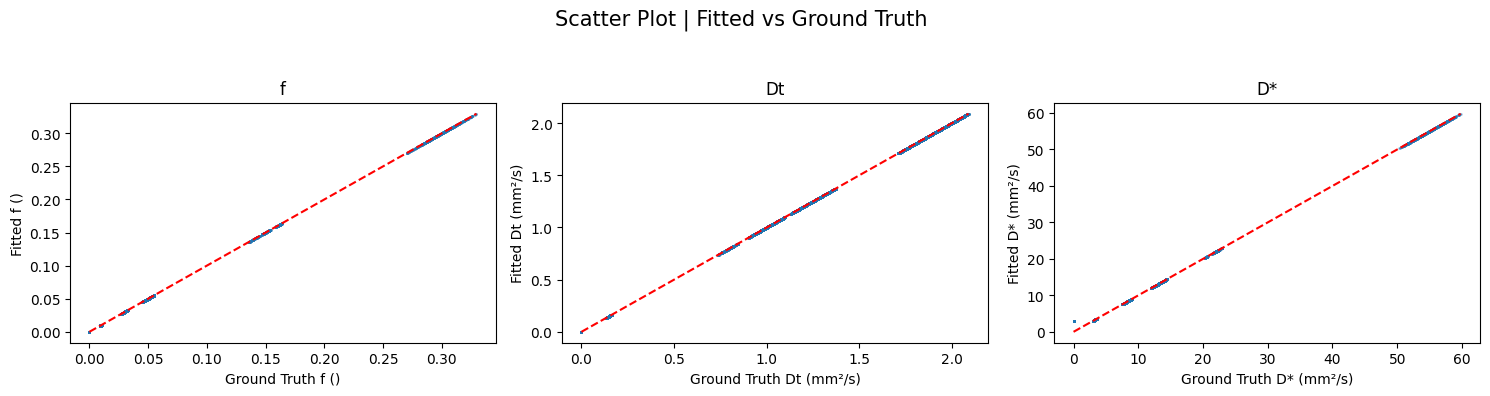

In [3]:
gt_dir = "../public_training_data/"
fit_dir = "../Result/fitted_NLLS/"


num_cases = 15


gt_all = []
fit_all = []

for i in range(1, num_cases + 1):
    case_id = f"{i:04d}"
    gt_path = os.path.join(gt_dir, f"{case_id}_IVIMParam.npy")
    fit_path = os.path.join(fit_dir, f"{case_id}_FittedParam.npy")

    gt = np.load(gt_path)     # shape: (H, W, 3)
    fit = np.load(fit_path)   # shape: (H, W, 3)

    gt_all.append(gt.reshape(-1, 3))   # (H*W, 3)
    fit_all.append(fit.reshape(-1, 3))


gt_all = np.concatenate(gt_all, axis=0)   # (total_voxels, 3)
fit_all = np.concatenate(fit_all, axis=0)

# 🧮 MAE 
mae = np.mean(np.abs(gt_all - fit_all), axis=0)
print("📊 Mean Absolute Error (MAE) :")
print(f"f     : {mae[0]:.6f}")
print(f"Dt    : {mae[1]:.6e}")
print(f"D*    : {mae[2]:.6e}")

# 📈 Scatter Plot
titles = ['f', 'Dt', 'D*']
units = ['', 'mm²/s', 'mm²/s']
scales = [1, 1e3, 1e3]  

plt.figure(figsize=(15, 4))
plt.suptitle("Scatter Plot | Fitted vs Ground Truth ", fontsize=15)

for i in range(3):
    plt.subplot(1, 3, i + 1)
    x = gt_all[:, i] * scales[i]
    y = fit_all[:, i] * scales[i]
    plt.scatter(x, y, s=1, alpha=0.3)
    plt.plot([x.min(), x.max()], [x.min(), x.max()], 'r--')
    plt.xlabel(f"Ground Truth {titles[i]} ({units[i]})")
    plt.ylabel(f"Fitted {titles[i]} ({units[i]})")
    plt.title(titles[i])

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



# Add Rician Noise and Save

In [17]:


input_dir = "../Result/simulated_DWI/"
output_dir = "../Result/noisy_DWI/"
os.makedirs(output_dir, exist_ok=True)


num_cases = 25
noise_levels = [2*0.0001, 5*0.0001, 7*0.0001, 0.001, 2*0.001, 5*0.001, 7*0.001, 0.01, 0.02, 0.05, 0.07, 0.1]

# 📌 Function of Rician noise
def add_rician_noise(S_clean, sigma):
    noise_real = np.random.normal(0, sigma, S_clean.shape)
    noise_imag = np.random.normal(0, sigma, S_clean.shape)
    S_noisy = np.sqrt((S_clean + noise_real) ** 2 + noise_imag ** 2)
    return S_noisy

# 🔁 Apply to all cases and noise levels
for i in range(1, num_cases + 1):
    case_id = f"{i:04d}"
    input_path = os.path.join(input_dir, f"{case_id}_SimulatedDWI.npy")
    S_clean = np.load(input_path)

    print(f"🔄 Case {case_id} is being processed...")

    for sigma in noise_levels:
        S_noisy = add_rician_noise(S_clean, sigma)
        sigma_tag = f"{sigma:.5f}".replace('.', 'p')  
        output_path = os.path.join(output_dir, f"{case_id}_sigma{sigma_tag}_NoisyDWI.npy")
        np.save(output_path, S_noisy)

    print(f"✅ {case_id} was recorded for all noise levels.")

print("\n🎯 Rician signals were generated and recorded with all noise levels for all 25 cases.")

🔄 Vaka 0001 işleniyor...
✅ Tüm noise seviyeleri için 0001 kaydedildi.
🔄 Vaka 0002 işleniyor...
✅ Tüm noise seviyeleri için 0002 kaydedildi.
🔄 Vaka 0003 işleniyor...
✅ Tüm noise seviyeleri için 0003 kaydedildi.
🔄 Vaka 0004 işleniyor...
✅ Tüm noise seviyeleri için 0004 kaydedildi.
🔄 Vaka 0005 işleniyor...
✅ Tüm noise seviyeleri için 0005 kaydedildi.
🔄 Vaka 0006 işleniyor...
✅ Tüm noise seviyeleri için 0006 kaydedildi.
🔄 Vaka 0007 işleniyor...
✅ Tüm noise seviyeleri için 0007 kaydedildi.
🔄 Vaka 0008 işleniyor...
✅ Tüm noise seviyeleri için 0008 kaydedildi.
🔄 Vaka 0009 işleniyor...
✅ Tüm noise seviyeleri için 0009 kaydedildi.
🔄 Vaka 0010 işleniyor...
✅ Tüm noise seviyeleri için 0010 kaydedildi.
🔄 Vaka 0011 işleniyor...
✅ Tüm noise seviyeleri için 0011 kaydedildi.
🔄 Vaka 0012 işleniyor...
✅ Tüm noise seviyeleri için 0012 kaydedildi.
🔄 Vaka 0013 işleniyor...
✅ Tüm noise seviyeleri için 0013 kaydedildi.
🔄 Vaka 0014 işleniyor...
✅ Tüm noise seviyeleri için 0014 kaydedildi.
🔄 Vaka 0015 işleniyo

# NLLS Fit + Save on Noisy Data

In [18]:

input_dir = "../Result/noisy_DWI/"
output_dir = "../Result/fitted_NLLS_noisy/"
os.makedirs(output_dir, exist_ok=True)


num_cases = 25
noise_levels = [2*0.0001, 5*0.0001, 7*0.0001, 0.001, 2*0.001, 5*0.001, 7*0.001, 0.01, 0.02, 0.05, 0.07, 0.1]
b_values = np.array([0, 5, 50, 100, 200, 500, 800, 1000])


for i in range(1, num_cases + 1):
    case_id = f"{i:04d}"
    print(f"\n🔄 Vaka {case_id} işleniyor...")

    for sigma in noise_levels:
        sigma_tag = f"{sigma:.5f}".replace('.', 'p')
        input_path = os.path.join(input_dir, f"{case_id}_sigma{sigma_tag}_NoisyDWI.npy")
        output_path = os.path.join(output_dir, f"{case_id}_sigma{sigma_tag}_FittedParam.npy")

     
        try:
            noisy_data = np.load(input_path)
        except FileNotFoundError:
            print(f"❌ Not Found Folder: {input_path}")
            continue

        # NLLS fit
        fitted = fit_biExponential_model(noisy_data, b_values)

        # Save
        np.save(output_path, fitted)
        print(f"✅ Saved → {output_path}")

print("\n🎯 All noisy signals were successfully fitted and recording was completed.")


🔄 Vaka 0001 işleniyor...
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00020_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00050_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00070_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00100_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00200_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00500_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p00700_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p01000_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p02000_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p05000_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p07000_FittedParam.npy
✅ Kaydedildi → ../Result/fitted_NLLS_noisy/0001_sigma0p10000_FittedParam.npy

🔄 Vaka 0002 işleniyor...
✅ Kaydedildi → ../Result

## MAE vs Noise Line Chart (NLLS)


📊 MAE | Case 0015
σ          MAE_f        MAE_Dt (×1e-3)     MAE_D* (×1e-3)    
----------------------------------------------------------
0.00020    0.000489     0.000632           268.406137        
0.00050    0.001061     0.001441           312.428671        
0.00070    0.001433     0.001975           318.187824        
0.00100    0.002018     0.002815           330.256795        
0.00200    0.004491     0.006075           355.396603        
0.00500    0.016904     0.019240           414.682813        
0.00700    0.023352     0.026296           450.577168        
0.01000    0.028907     0.033684           491.624701        
0.02000    0.041413     0.055595           587.641683        
0.05000    0.067406     0.118958           708.696074        
0.07000    0.079834     0.155274           759.840028        
0.10000    0.095868     0.203328           806.644271        


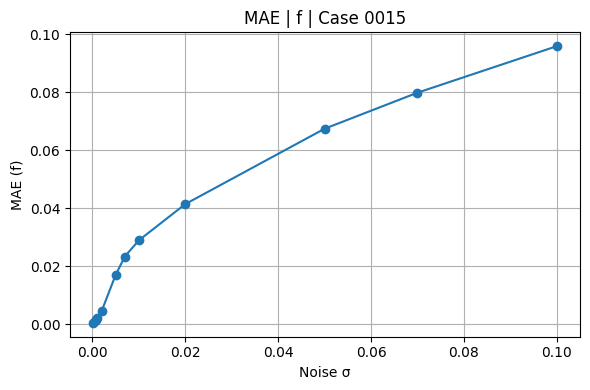

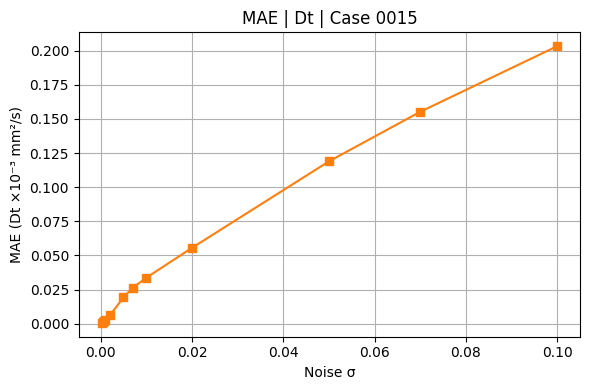

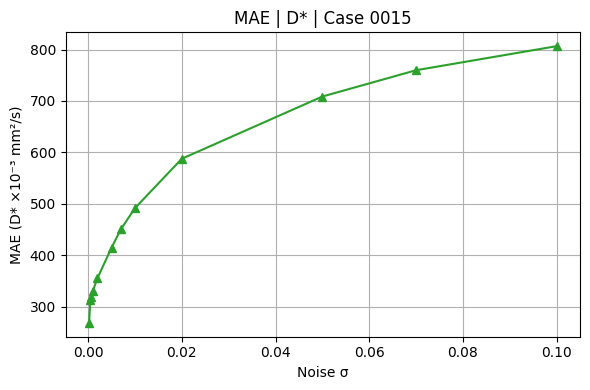

In [4]:

# 🎯 Example Case
case_id = "0015"


gt_path = f"../public_training_data/{case_id}_IVIMParam.npy"
fit_dir = "../Result/fitted_NLLS_noisy/"

# 📌 Noise levels
noise_levels = [2*0.0001, 5*0.0001, 7*0.0001, 0.001, 2*0.001, 5*0.001, 7*0.001, 0.01, 0.02, 0.05, 0.07, 0.1]
noise_tags = [f"{s:.5f}".replace('.', 'p') for s in noise_levels]

# 🔄 MAE 
mae_f, mae_Dt, mae_Ds = [], [], []


gt = np.load(gt_path).reshape(-1, 3)

# 🔁 Calculate MAE each noıse level 
print(f"\n📊 MAE | Case {case_id}")
print(f"{'σ':<10} {'MAE_f':<12} {'MAE_Dt (×1e-3)':<18} {'MAE_D* (×1e-3)':<18}")
print("-" * 58)

for sigma, tag in zip(noise_levels, noise_tags):
    fit_path = os.path.join(fit_dir, f"{case_id}_sigma{tag}_FittedParam.npy")
    fit = np.load(fit_path).reshape(-1, 3)
    mae = np.mean(np.abs(gt - fit), axis=0)

    mae_f.append(mae[0])
    mae_Dt.append(mae[1])
    mae_Ds.append(mae[2])

   
    print(f"{sigma:<10.5f} {mae[0]:<12.6f} {mae[1]*1e3:<18.6f} {mae[2]*1e3:<18.6f}")

# 📈 f 
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, mae_f, marker='o', color='tab:blue')
plt.xlabel("Noise σ")
plt.ylabel("MAE (f)")
plt.title(f"MAE | f | Case {case_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Dt 
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, np.array(mae_Dt) * 1e3, marker='s', color='tab:orange')
plt.xlabel("Noise σ")
plt.ylabel("MAE (Dt ×10⁻³ mm²/s)")
plt.title(f"MAE | Dt | Case {case_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 D* 
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, np.array(mae_Ds) * 1e3, marker='^', color='tab:green')
plt.xlabel("Noise σ")
plt.ylabel("MAE (D* ×10⁻³ mm²/s)")
plt.title(f"MAE | D* | Case {case_id}")
plt.grid(True)
plt.tight_layout()
plt.show()






📊 MAE | Case 0015
σ          MAE_f        MAE_Dt (×1e-3)     MAE_D* (×1e-3)    
----------------------------------------------------------
0.00020    0.000489     0.000632           268.406137        
0.00050    0.001061     0.001441           312.428671        
0.00070    0.001433     0.001975           318.187824        
0.00100    0.002018     0.002815           330.256795        
0.00200    0.004491     0.006075           355.396603        
0.00500    0.016904     0.019240           414.682813        
0.00700    0.023352     0.026296           450.577168        
0.01000    0.028907     0.033684           491.624701        
0.02000    0.041413     0.055595           587.641683        
0.05000    0.067406     0.118958           708.696074        
0.07000    0.079834     0.155274           759.840028        
0.10000    0.095868     0.203328           806.644271        


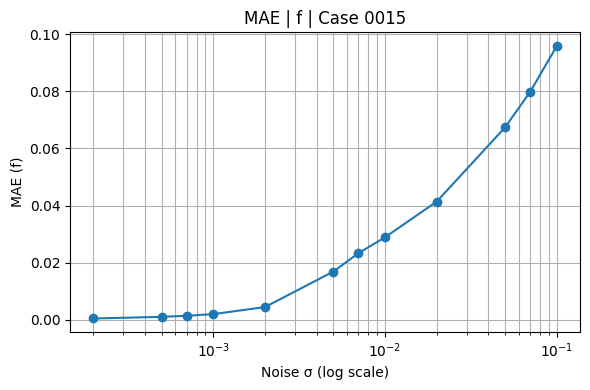

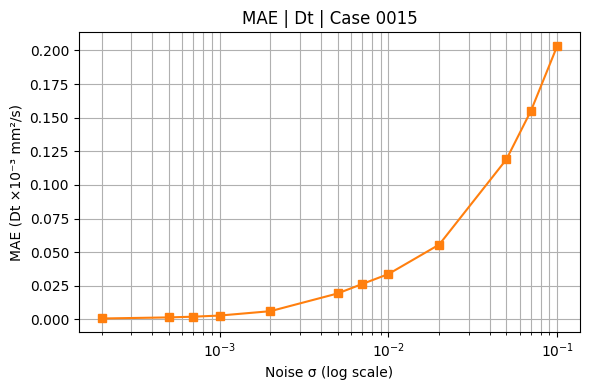

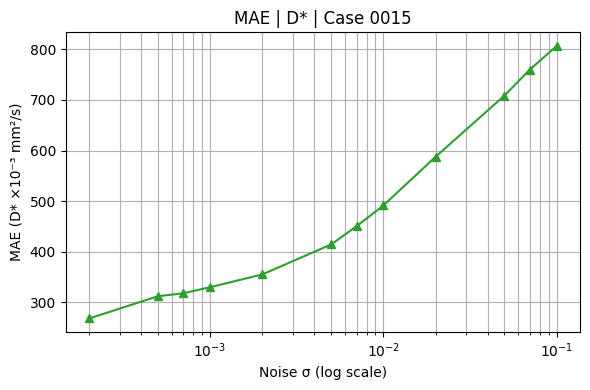

In [5]:
# 🎯 Example Case
case_id = "0015"


gt_path = f"../public_training_data/{case_id}_IVIMParam.npy"
fit_dir = "../Result/fitted_NLLS_noisy/"

# 📌 Noise levels
noise_levels = [2*0.0001, 5*0.0001, 7*0.0001, 0.001, 2*0.001, 5*0.001, 7*0.001, 0.01, 0.02, 0.05, 0.07, 0.1]
noise_tags = [f"{s:.5f}".replace('.', 'p') for s in noise_levels]

# 🔄 MAE 
mae_f, mae_Dt, mae_Ds = [], [], []

# ✅ GT
gt = np.load(gt_path).reshape(-1, 3)

# 🔁 Calculate MAE each noıse level 
print(f"\n📊 MAE | Case {case_id}")
print(f"{'σ':<10} {'MAE_f':<12} {'MAE_Dt (×1e-3)':<18} {'MAE_D* (×1e-3)':<18}")
print("-" * 58)

for sigma, tag in zip(noise_levels, noise_tags):
    fit_path = os.path.join(fit_dir, f"{case_id}_sigma{tag}_FittedParam.npy")
    fit = np.load(fit_path).reshape(-1, 3)
    mae = np.mean(np.abs(gt - fit), axis=0)

    mae_f.append(mae[0])
    mae_Dt.append(mae[1])
    mae_Ds.append(mae[2])

    
    print(f"{sigma:<10.5f} {mae[0]:<12.6f} {mae[1]*1e3:<18.6f} {mae[2]*1e3:<18.6f}")

# 📈 f 
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, mae_f, marker='o', color='tab:blue')
plt.xscale("log")  # X ekseni log-scale
plt.xlabel("Noise σ (log scale)")
plt.ylabel("MAE (f)")
plt.title(f"MAE | f | Case {case_id}")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

# 📈 Dt 
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, np.array(mae_Dt) * 1e3, marker='s', color='tab:orange')
plt.xscale("log")  # X ekseni log-scale
plt.xlabel("Noise σ (log scale)")
plt.ylabel("MAE (Dt ×10⁻³ mm²/s)")
plt.title(f"MAE | Dt | Case {case_id}")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

# 📈 D* 
plt.figure(figsize=(6, 4))
plt.plot(noise_levels, np.array(mae_Ds) * 1e3, marker='^', color='tab:green')
plt.xscale("log")  # X ekseni log-scale
plt.xlabel("Noise σ (log scale)")
plt.ylabel("MAE (D* ×10⁻³ mm²/s)")
plt.title(f"MAE | D* | Case {case_id}")
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


# GT vs Fitted Scatter Plot (f, Dt, D* 12 noise levels)

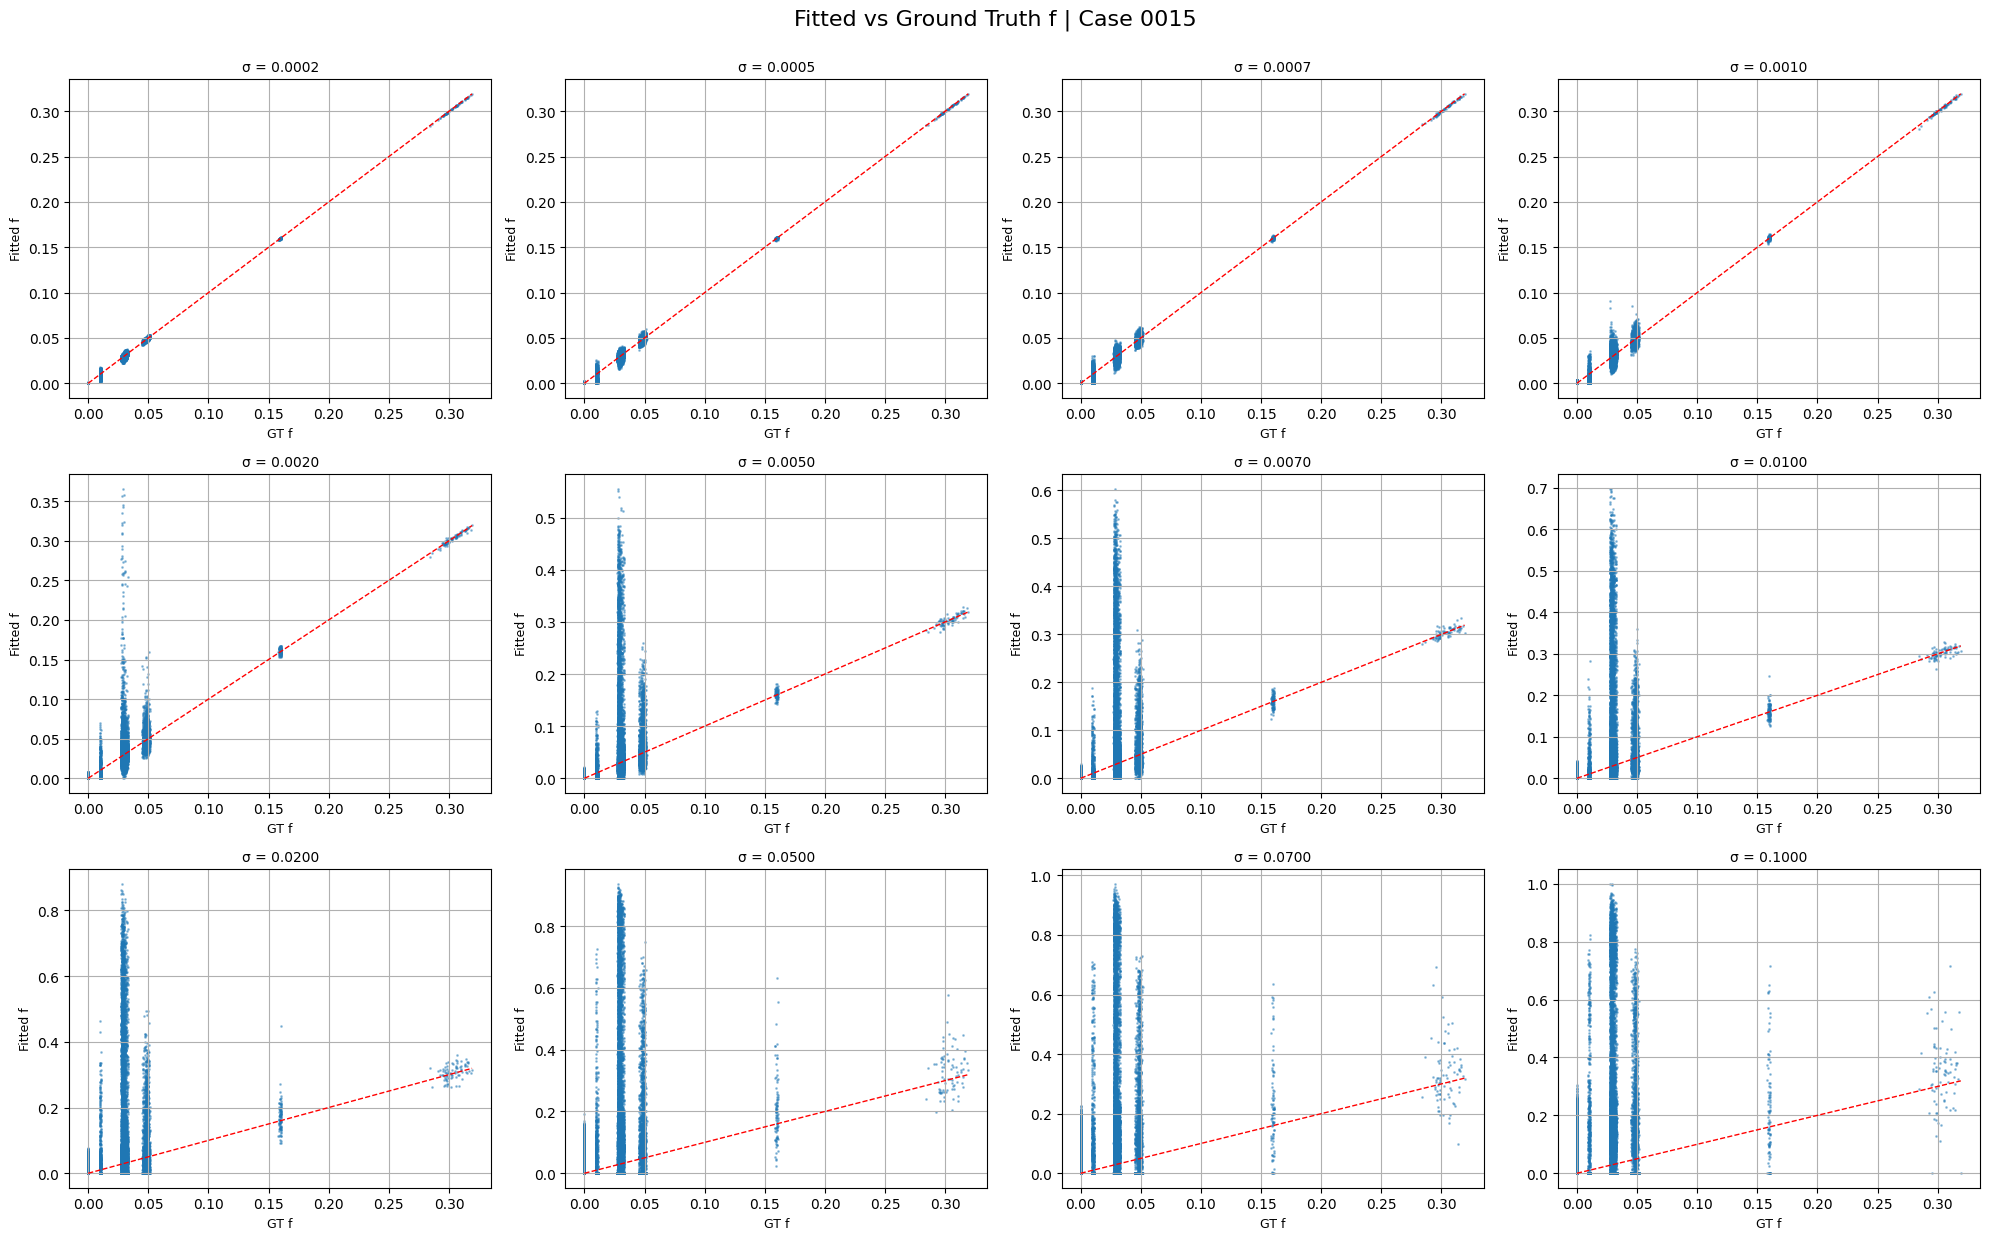

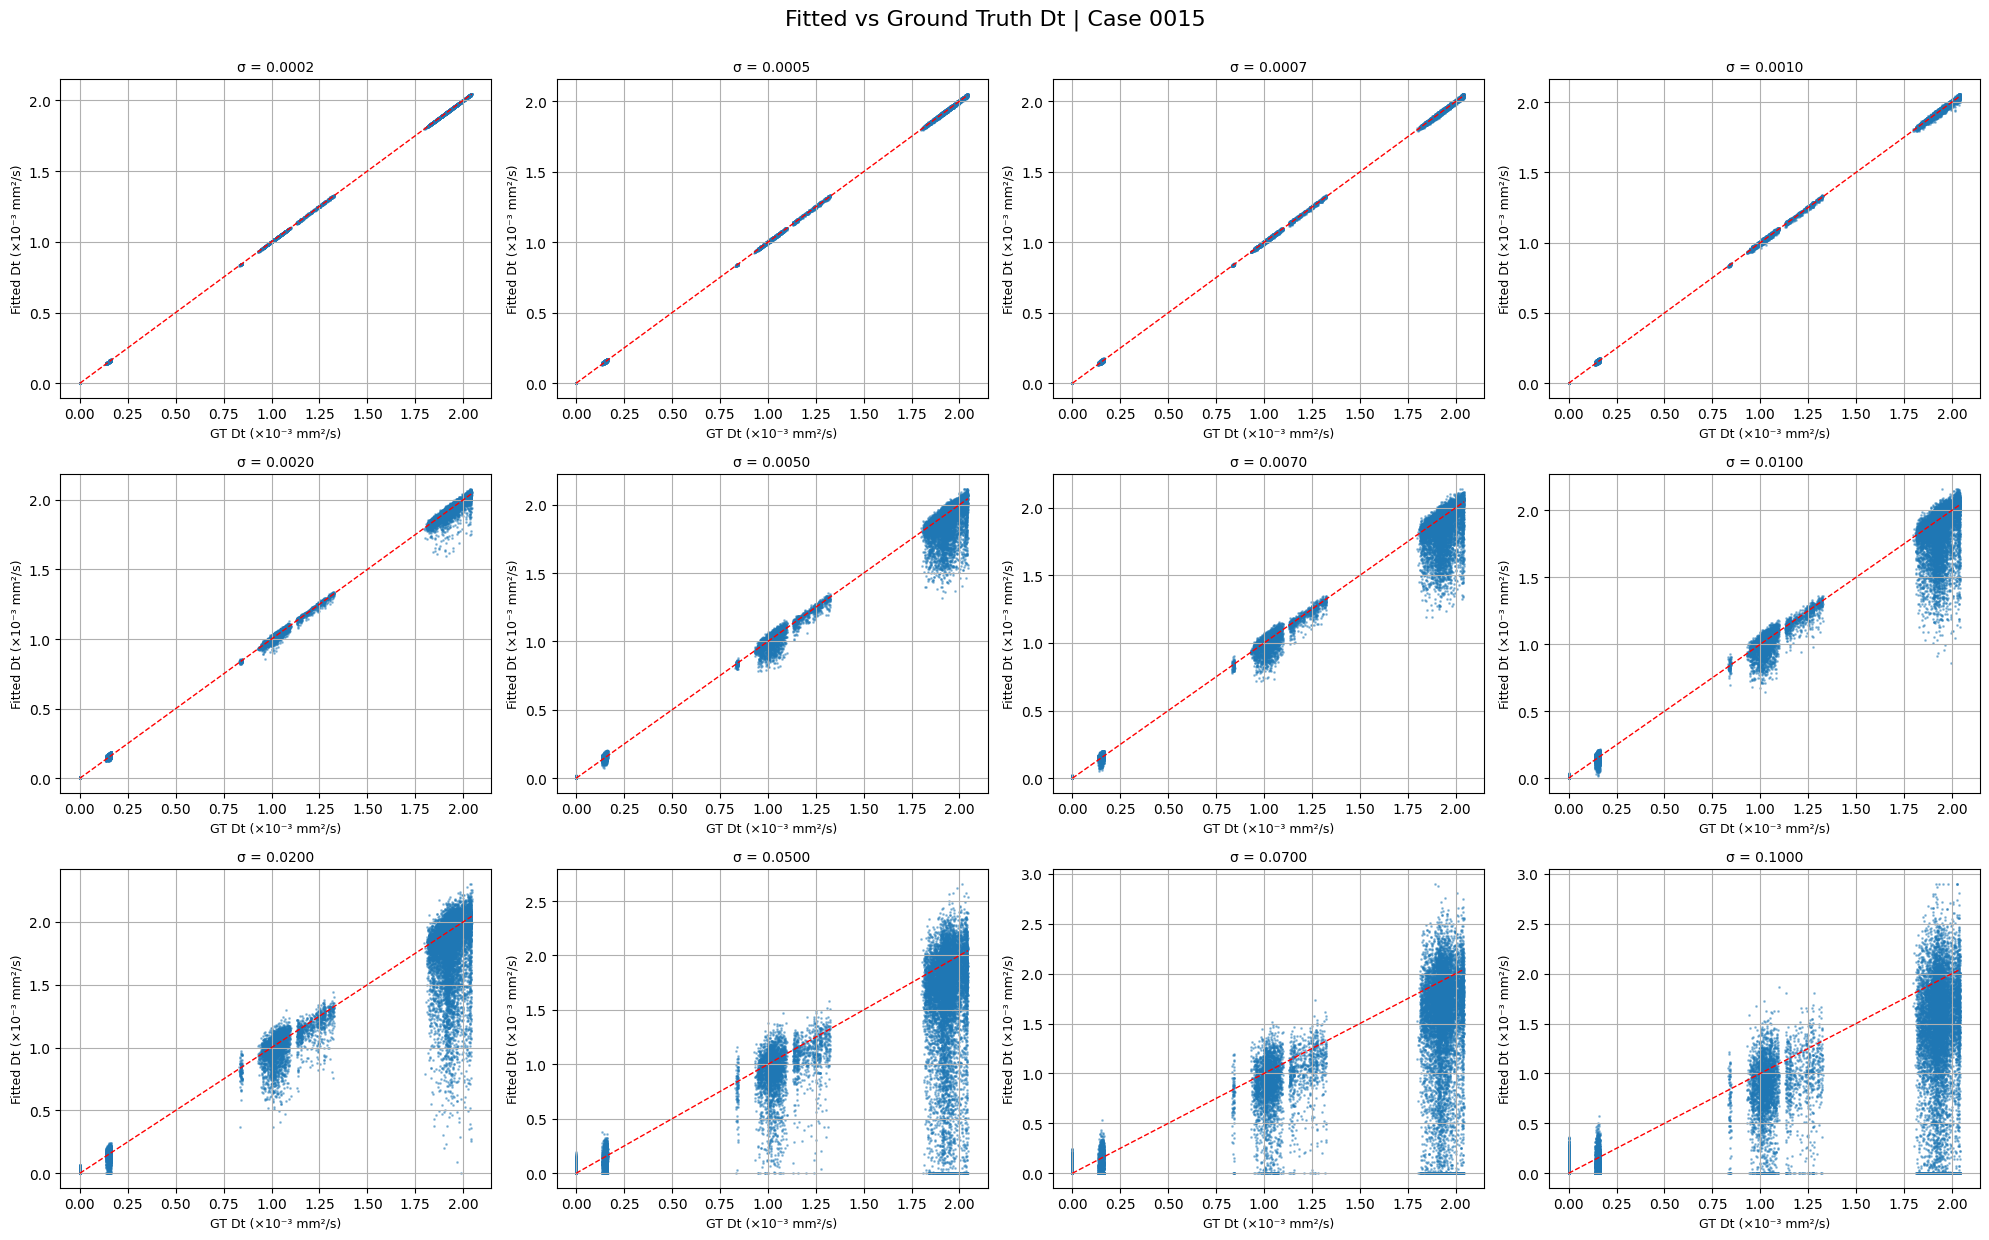

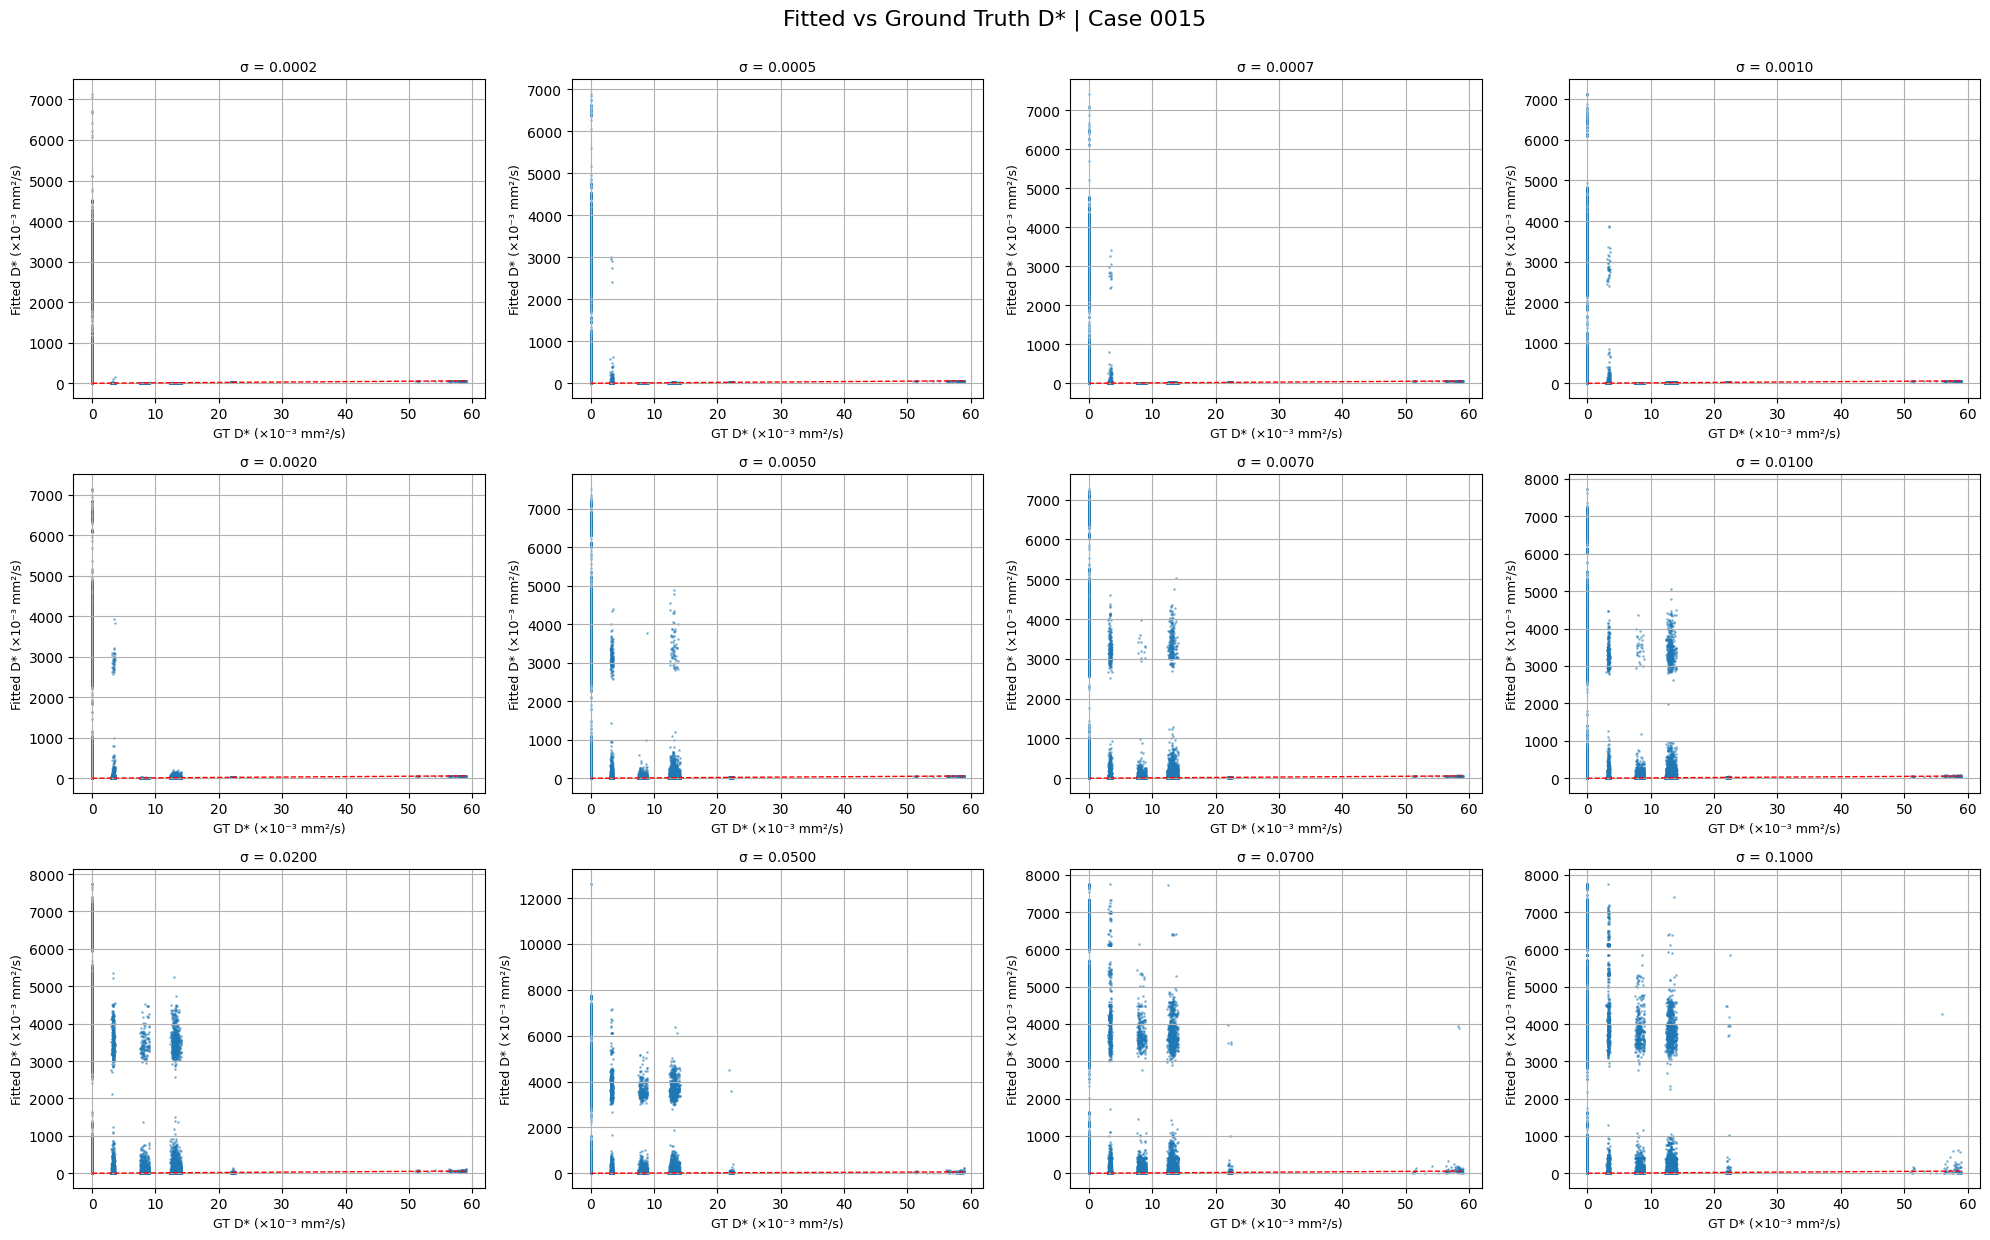

In [6]:


case_id = "0015"
noise_levels = [2*0.0001, 5*0.0001, 7*0.0001, 0.001, 2*0.001, 5*0.001,
                7*0.001, 0.01, 0.02, 0.05, 0.07, 0.1]
noise_tags = [f"{s:.5f}".replace('.', 'p') for s in noise_levels]


gt_path = f"../public_training_data/{case_id}_IVIMParam.npy"
fit_dir = "../Result/fitted_NLLS_noisy/"


gt = np.load(gt_path).reshape(-1, 3)  # (N_voxel, 3)


param_names = ['f', 'Dt', 'D*']
gt_idx = [0, 1, 2]
units = ['', ' (×10⁻³ mm²/s)', ' (×10⁻³ mm²/s)']
scales = [1, 1e3, 1e3]  # Dt ve D*'yi daha okunabilir yapmak için

for p, name in zip(gt_idx, param_names):
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    axes = axes.flatten()

    for i, tag in enumerate(noise_tags):
        fit_path = os.path.join(fit_dir, f"{case_id}_sigma{tag}_FittedParam.npy")
        fit = np.load(fit_path).reshape(-1, 3)

        x = gt[:, p] * scales[p]
        y = fit[:, p] * scales[p]

        ax = axes[i]
        ax.scatter(x, y, s=1, alpha=0.4)
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', linewidth=1)
        ax.set_title(f"σ = {noise_levels[i]:.4f}", fontsize=10)
        ax.set_xlabel(f"GT {name}{units[p]}", fontsize=9)
        ax.set_ylabel(f"Fitted {name}{units[p]}", fontsize=9)
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle(f"Fitted vs Ground Truth {name} | Case {case_id}", fontsize=16, y=1.03)
    plt.show()
